# XXZ model


In [22]:
from datetime import datetime

from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit
import pytket.qasm

from scipy.optimize import minimize
from numpy import ndarray
from numpy.random import random_sample
from sympy import Symbol
from functools import partial

import qnexus as qnx
from copy import deepcopy
import matplotlib.pyplot as plt

In [23]:
# qibo's
import qibo
from qibo import gates, hamiltonians, models
from qibo.backends import construct_backend
from qibo.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)


# boostvqe's
from boostvqe import ansatze
from boostvqe.plotscripts import plot_gradients, plot_loss
from boostvqe.training_utils import Model, vqe_loss, TLFIM
from boostvqe.models.dbi.double_bracket_evolution_oracles import *
from boostvqe.utils import (
    OPTIMIZATION_FILE,
    PARAMS_FILE,
    optimize_D,
    select_recursion_step_gd_circuit,
    apply_dbi_steps,
    create_folder,
    generate_path,
    results_dump,
    rotate_h_with_vqe,
    train_vqe,
)
from boostvqe.models.dbi.group_commutator_iteration_transpiler import (
    DoubleBracketRotationType,
    GroupCommutatorIterationWithEvolutionOracles,
)
import numpy as np
import json
import matplotlib.pyplot as plt

In [24]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

In [25]:
qibo.set_backend("tensorflow")
vqe_backend = construct_backend(backend="tensorflow")

[Qibo 0.2.12|INFO|2024-10-30 10:50:25]: Using tensorflow backend on /device:CPU:0
INFO:qibo.config:Using tensorflow backend on /device:CPU:0


[Qibo 0.2.12|WARNING|2024-10-30 10:50:25]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


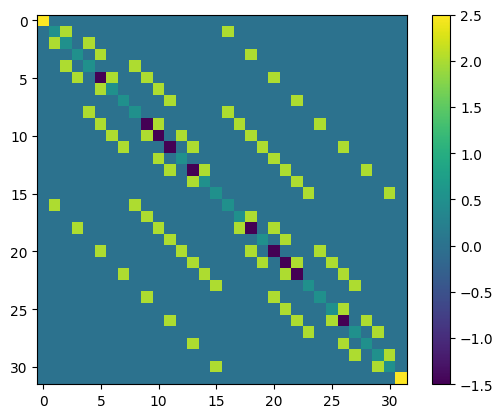

In [26]:
nqubits = 5
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

## Train VQE from notebook

In [29]:
# build ansatz circuit
nlayer = 1
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayer)
print(ansatz_circ.draw())

[Qibo 0.2.12|WARNING|2024-10-30 10:50:34]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───|─RY─
q4: ─RY─RZ─────RY─RZ───Z─RY─


In [30]:
# build zero state
zero_state = ham.backend.zero_state(nqubits)
# initial params
params_len = len(ansatz_circ.get_parameters())
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print(initial_params)
# initial energy
c0 = deepcopy(ansatz_circ)
c0.set_parameters(initial_params)
target_energy = np.real(np.min(np.asarray(ham.eigenvalues())))
print('Target enegry:', target_energy)
print('Initial energy:', exact_expectation_boost(ham, c0))

[ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294]
Target enegry: -6.280513769031045
Initial energy: tf.Tensor(1.0802335771641438, shape=(), dtype=float64)


In [31]:
niter = 1
# define the qibo loss function
objective_boost = partial(vqe_loss)
# logging hisotry
params_history, loss_history, grads_history, fluctuations = [], [], [], []
# set optimizer
optimizer = 'sgd'
tol = 1e-2

In [46]:
# train vqe
(
    partial_results,
    partial_params_history,
    partial_loss_history,
    partial_grads_history,
    partial_fluctuations,
    vqe,
) = train_vqe(
    deepcopy(ansatz_circ),
    ham,  # Fixed hamiltonian
    optimizer,
    initial_params,
    tol=tol,
    niterations=1,
    nmessage=1,
    loss=objective_boost,
    training_options={'nepochs':10000,}
)
params_history = np.array(partial_params_history)
loss_history = np.array(partial_loss_history)
grads_history = np.array(partial_grads_history)
fluctuations = np.array(partial_fluctuations)

INFO:root:Optimization iteration 0/1
INFO:root:Loss 1.0802
INFO:root:Minimize the energy
INFO:root:Optimization iteration 1/1
INFO:root:Loss 1.0756
INFO:root:Optimization iteration 2/1
INFO:root:Loss 1.0718
[Qibo 0.2.12|INFO|2024-10-30 14:53:39]: ite 1 : loss 1.075567
INFO:qibo.config:ite 1 : loss 1.075567
INFO:root:Optimization iteration 3/1
INFO:root:Loss 1.0686
INFO:root:Optimization iteration 4/1
INFO:root:Loss 1.0657
INFO:root:Optimization iteration 5/1
INFO:root:Loss 1.0631
INFO:root:Optimization iteration 6/1
INFO:root:Loss 1.0606
INFO:root:Optimization iteration 7/1
INFO:root:Loss 1.0583
INFO:root:Optimization iteration 8/1
INFO:root:Loss 1.0561
INFO:root:Optimization iteration 9/1
INFO:root:Loss 1.0541
INFO:root:Optimization iteration 10/1
INFO:root:Loss 1.0521
INFO:root:Optimization iteration 11/1
INFO:root:Loss 1.0502
INFO:root:Optimization iteration 12/1
INFO:root:Loss 1.0484
INFO:root:Optimization iteration 13/1
INFO:root:Loss 1.0466
INFO:root:Optimization iteration 14/1
I

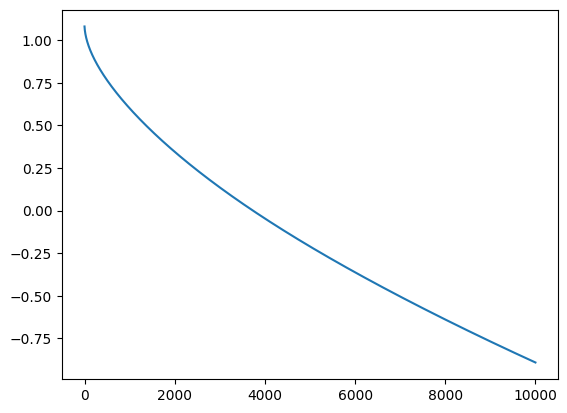

In [47]:
plt.plot(loss_history)

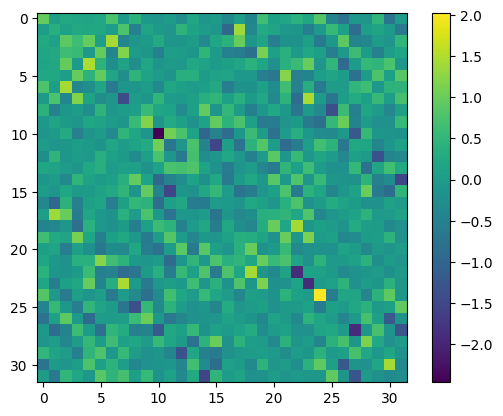

In [35]:
# obtain rotated hamiltonian
new_ham_matrix = rotate_h_with_vqe(hamiltonian=ham, vqe=vqe)
new_ham = hamiltonians.Hamiltonian(
                nqubits, matrix=new_ham_matrix
            )
plt.imshow(np.real(new_ham.matrix))
plt.colorbar()

## Run GCI

In [40]:
# step: Number of time steps (default 1).
# order: the order of product formula, as of now, it takes value 1 or 2
steps = 1
order = 1
ham_base_eo = XXZ_EvolutionOracle.from_nqubits(
        nqubits=nqubits, delta=0.5, steps=steps, order=order
    )

In [41]:
# we then rotrate H_XXZ with VQE using the FrameShiftedOracle e^{i H' t} = V e^{i H0 t} Vdag
frame_shifted_oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
        circuit_frame = vqe.circuit,
        base_evolution_oracle=ham_base_eo,)

AttributeError: 'FrameShiftedEvolutionOracle' object has no attribute 'steps'

In [ ]:
# shifted oracle is passed to the group commutator
db_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
gci = GroupCommutatorIterationWithEvolutionOracles(
    frame_shifted_oracle
    db_rotation,
)